In [2]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import nilmtk
from nilmtk import DataSet, MeterGroup
from sklearn.ensemble import RandomForestClassifier

plt.style.use('ggplot')
rcParams['figure.figsize'] = (13, 10)
caminho_ukdale = 'ukdale.h5'

# Lendo Dataset do Ukdale
ukdale = DataSet(caminho_ukdale)

# Lendo eletrodomesticos da Casa 1
elec = ukdale.buildings[1].elec

# Criando objeto do kettle
kettle = elec['kettle']

ModuleNotFoundError: No module named 'nilmtk'

In [5]:
elec = ukdale.buildings[1].elec

NameError: name 'ukdale' is not defined

In [6]:
#ukdale.set_window(start='2013-04-01', end='2013-06-03')
#elec.plot();
#plt.xlabel("Time");
#plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

Criando objeto do kettle

In [3]:
kettle = elec['kettle']

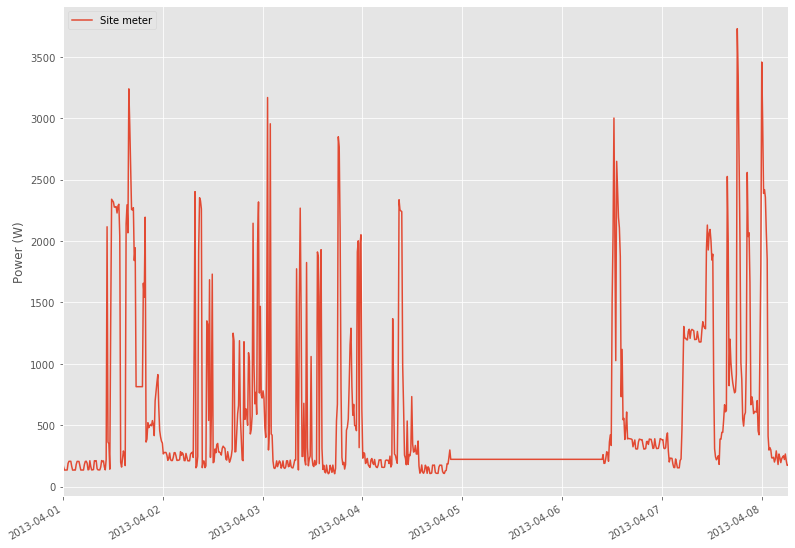

In [20]:
#elec.mains().plot()

Transformando meters do NILMTK em dataframes do Pandas

In [4]:
main_series = elec.mains().power_series_all_data()
kettle_df_first = next(kettle.load())
kettle_series = kettle_df_first['power']['active']

In [5]:
main_df = pd.DataFrame(data={'time': main_series.index, 'pwr': main_series.values})
kettle_df = pd.DataFrame(data={'time': kettle_series.index, 'pwr': kettle_series.values})

Upsample do main_df

In [6]:
kettle_df = kettle_df.sort_values(by='time')
main_df = main_df.sort_values(by='time')
kettle_df = kettle_df.set_index('time')
kettle_df = kettle_df[kettle_df.index >= main_df['time'].iloc[0]]
kettle_df.head()

,pwr
time,
2013-03-17 19:12:47+00:00,1.0
2013-03-17 19:12:53+00:00,1.0
2013-03-17 19:13:00+00:00,1.0
2013-03-17 19:13:06+00:00,1.0
2013-03-17 19:13:12+00:00,1.0


In [7]:
main_df = main_df.set_index('time')
main_df = main_df.resample('6S', base=5).mean().interpolate()
main_df = main_df[main_df.index >= main_df.index[1]]
main_df.head()

,pwr
time,
2013-03-17 19:12:47+00:00,339.978333
2013-03-17 19:12:53+00:00,339.095001
2013-03-17 19:12:59+00:00,338.913330
2013-03-17 19:13:05+00:00,340.413330
2013-03-17 19:13:11+00:00,340.403320


In [8]:
main_df = main_df[main_df.index <=kettle_df.index[-1]]

In [9]:
kettle_df = kettle_df.resample('6S', base=5).mean().interpolate()
kettle_df.head()

,pwr
time,
2013-03-17 19:12:47+00:00,1.0
2013-03-17 19:12:53+00:00,1.0
2013-03-17 19:12:59+00:00,1.0
2013-03-17 19:13:05+00:00,1.0
2013-03-17 19:13:11+00:00,1.0


In [10]:
main_df = main_df.rename(columns={"pwr": "mains"})
kettle_df = kettle_df.rename(columns={"pwr": "kettle"})
kettle_mains_df = main_df.merge(kettle_df, left_index=True, right_index=True)
kettle_mains_df['time'] = kettle_mains_df.index
kettle_mains_df['dia_semana'] = kettle_mains_df.time.dt.dayofweek
kettle_mains_df['hora'] = kettle_mains_df.time.dt.hour
kettle_mains_df.head()

,mains,kettle,time,dia_semana,hora
time,,,,,
2013-03-17 19:12:47+00:00,339.978333,1.0,2013-03-17 19:12:47+00:00,6,19
2013-03-17 19:12:53+00:00,339.095001,1.0,2013-03-17 19:12:53+00:00,6,19
2013-03-17 19:12:59+00:00,338.913330,1.0,2013-03-17 19:12:59+00:00,6,19
2013-03-17 19:13:05+00:00,340.413330,1.0,2013-03-17 19:13:05+00:00,6,19
2013-03-17 19:13:11+00:00,340.403320,1.0,2013-03-17 19:13:11+00:00,6,19


Fazendo a interpolação dos pontos do kettle (depois)

In [11]:
kettle_mains_df['ligado'] = kettle_mains_df['kettle'] > 2000.0
kettle_mains_df[kettle_mains_df['ligado'] == True]

,mains,kettle,time,dia_semana,hora,ligado
time,,,,,,
2013-03-17 20:45:35+00:00,3094.785156,2348.0,2013-03-17 20:45:35+00:00,6,20,True
2013-03-17 20:45:41+00:00,3053.368408,2318.0,2013-03-17 20:45:41+00:00,6,20,True
2013-03-17 20:45:47+00:00,3050.353271,2307.5,2013-03-17 20:45:47+00:00,6,20,True
2013-03-17 20:45:53+00:00,3056.416748,2297.0,2013-03-17 20:45:53+00:00,6,20,True
2013-03-17 20:45:59+00:00,3073.836670,2267.0,2013-03-17 20:45:59+00:00,6,20,True
...,...,...,...,...,...,...
2014-12-26 12:25:29+00:00,3049.660156,2308.0,2014-12-26 12:25:29+00:00,4,12,True
2014-12-26 12:25:35+00:00,3040.446777,2324.0,2014-12-26 12:25:35+00:00,4,12,True
2014-12-26 12:25:41+00:00,3040.554932,2326.0,2014-12-26 12:25:41+00:00,4,12,True


In [58]:
kettle_mains_df['timestamp'] = kettle_mains_df['time'].apply(lambda x: x.timestamp())

# Desagregação!


Testando classificadores genéricos

In [62]:
test_train_divide = kettle_mains_df['time'].iloc[1000000]
test_train_divide

Timestamp('2013-05-26 06:52:47+0100', tz='Europe/London', freq='6S')

In [63]:
test_end = kettle_mains_df['time'].iloc[1500000]
test_end

Timestamp('2013-06-30 00:12:47+0100', tz='Europe/London', freq='6S')

In [64]:
train = kettle_mains_df[kettle_mains_df['time'] < test_train_divide]
test = kettle_mains_df[kettle_mains_df['time'] >= test_train_divide]
test = test[test['time'] < test_end]

In [67]:
test.head()

,mains,kettle,time,dia_semana,hora,ligado,timestamp
time,,,,,,,
2013-05-26 06:52:47+01:00,93.543335,1.0,2013-05-26 06:52:47+01:00,6,6,False,1.369548e+09
2013-05-26 06:52:53+01:00,93.506668,1.0,2013-05-26 06:52:53+01:00,6,6,False,1.369548e+09
2013-05-26 06:52:59+01:00,93.275002,1.0,2013-05-26 06:52:59+01:00,6,6,False,1.369548e+09
2013-05-26 06:53:05+01:00,93.455002,1.0,2013-05-26 06:53:05+01:00,6,6,False,1.369548e+09
2013-05-26 06:53:11+01:00,93.358330,1.0,2013-05-26 06:53:11+01:00,6,6,False,1.369548e+09


In [ ]:
train.to_csv(index=False)

In [68]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(train[['mains', 'dia_semana', 'hora', 'timestamp']], train['ligado'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [69]:
y_pred = clf.predict(test[['mains', 'dia_semana', 'hora', 'timestamp']])

In [70]:
y = test['ligado']

In [71]:
acertos = 0
erros = 0
trues_iguais = 0
for i in range(len(y)):
    if y_pred[i] == y[i]:
        if y[i] == True:
            trues_iguais += 1
        acertos += 1
    else:
        erros += 1

print("acertos: " + str(acertos))
print("trues iguais: " + str(trues_iguais))
print("erros: " + str(erros))

acertos: 498557
trues iguais: 1333
erros: 1443


In [72]:
trues_y = 0
trues_y_pred = 0
for i in range(len(y)):
    if y[i] == True:
        trues_y += 1
    if y_pred[i] == True:
        trues_y_pred += 1

falses_y = len(y) - trues_y
falses_y_pred = len(y_pred) - trues_y_pred
print("trues y: " + str(trues_y))
print("falses y: " + str(falses_y))
print("trues y pred: " + str(trues_y_pred))
print("falses y pred: " + str(falses_y_pred))

trues y: 1961
falses y: 498039
trues y pred: 2148
falses y pred: 497852


Averiguando resultado no Dataset de teste

In [73]:
test['ligado_predicao'] = y_pred

In [75]:
ini_true_tests = test[(test['ligado'] == True) & (test['ligado_predicao'] == True)].index[0]
test[test.index > ini_true_tests].head(20)

,mains,kettle,time,dia_semana,hora,ligado,timestamp,ligado_predicao
time,,,,,,,,
2013-05-31 08:48:11+01:00,2686.739990,2340.0,2013-05-31 08:48:11+01:00,4,8,True,1.369986e+09,True
2013-05-31 08:48:17+01:00,2691.678223,2330.0,2013-05-31 08:48:17+01:00,4,8,True,1.369986e+09,True
2013-05-31 08:48:23+01:00,2692.564941,2321.0,2013-05-31 08:48:23+01:00,4,8,True,1.369987e+09,True
2013-05-31 08:48:29+01:00,2697.283447,2314.0,2013-05-31 08:48:29+01:00,4,8,True,1.369987e+09,True
2013-05-31 08:48:35+01:00,2691.024902,2351.0,2013-05-31 08:48:35+01:00,4,8,True,1.369987e+09,True
2013-05-31 08:48:41+01:00,2688.563232,2315.0,2013-05-31 08:48:41+01:00,4,8,True,1.369987e+09,True
2013-05-31 08:48:47+01:00,2692.268311,2313.0,2013-05-31 08:48:47+01:00,4,8,True,1.369987e+09,True
2013-05-31 08:48:53+01:00,2694.231689,2311.0,2013-05-31 08:48:53+01:00,4,8,True,1.369987e+09,True
2013-05-31 08:48:59+01:00,2695.294922,2341.0,2013-05-31 08:48:59+01:00,4,8,True,1.369987e+09,True


In [76]:
test[(test['ligado'] == False) & (test['ligado_predicao'] == True)]

,mains,kettle,time,dia_semana,hora,ligado,timestamp,ligado_predicao
time,,,,,,,,
2013-05-31 08:47:59+01:00,2731.320068,2.0,2013-05-31 08:47:59+01:00,4,8,False,1.369986e+09,True
2013-06-01 19:56:17+01:00,2599.146729,1192.5,2013-06-01 19:56:17+01:00,5,19,False,1.370113e+09,True
2013-06-01 20:12:59+01:00,2672.208252,10.0,2013-06-01 20:12:59+01:00,5,20,False,1.370114e+09,True
2013-06-02 09:44:11+01:00,3434.228271,1.0,2013-06-02 09:44:11+01:00,6,9,False,1.370163e+09,True
2013-06-02 09:44:17+01:00,4210.683594,1.0,2013-06-02 09:44:17+01:00,6,9,False,1.370163e+09,True
...,...,...,...,...,...,...,...,...
2013-06-29 08:44:05+01:00,2553.581787,1.0,2013-06-29 08:44:05+01:00,5,8,False,1.372492e+09,True
2013-06-29 08:44:17+01:00,2598.905029,1.0,2013-06-29 08:44:17+01:00,5,8,False,1.372492e+09,True
2013-06-29 08:44:29+01:00,2524.161621,1.0,2013-06-29 08:44:29+01:00,5,8,False,1.372492e+09,True


Testando coisas do próprio NILMTK

In [4]:
from __future__ import print_function, division
import time
import numpy as np
from six import iteritems

from nilmtk import TimeFrame, HDFDataStore
from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM
import nilmtk.utils


train = DataSet(caminho_ukdale)
test = DataSet(caminho_ukdale)

In [5]:
train.set_window(end="2013-04-01")
test.set_window(start="2013-04-01")

train_elec = train.buildings[3].elec
test_elec = test.buildings[3].elec

In [6]:
mains_df = next(train_elec.mains().load())
mains_df.head()

physical_quantity,power
type,apparent
2013-02-27 20:35:14+00:00,5.0
2013-02-27 20:35:20+00:00,4.0
2013-02-27 20:35:26+00:00,5.0
2013-02-27 20:35:32+00:00,5.0
2013-02-27 20:35:38+00:00,4.0


In [8]:
kettle = train_elec['kettle']
kettle_df = next(kettle.load())
kettle_df.head()

physical_quantity,power
type,active
2013-02-27 20:35:20+00:00,1.0
2013-02-27 20:35:26+00:00,1.0
2013-02-27 20:35:33+00:00,1.0
2013-02-27 20:35:39+00:00,1.0
2013-02-27 20:35:45+00:00,1.0


In [19]:
kettle_train = train_elec.select_using_appliances(type=['kettle'])

In [20]:
kettle_train

MeterGroup(meters=
  ElecMeter(instance=2, building=3, dataset='UK-DALE', appliances=[Appliance(type='kettle', instance=1)])
)

Função para desagregar

In [12]:
def predict(clf, test_elec, sample_period, timezone):
    pred = {}
    gt= {}
    
    # "ac_type" varies according to the dataset used. 
    # Make sure to use the correct ac_type before using the default parameters in this code.    
    for i, chunk in enumerate(test_elec.mains().load(physical_quantity = 'power', ac_type = 'apparent', sample_period=sample_period)):
        chunk_drop_na = chunk.dropna()
        pred[i] = clf.disaggregate_chunk(chunk_drop_na)
        gt[i]={}

        for meter in test_elec.submeters().meters:
            # Only use the meters that we trained on (this saves time!)    
            gt[i][meter] = next(meter.load(physical_quantity = 'power', ac_type = 'active', sample_period=sample_period))
        gt[i] = pd.DataFrame({k:v.squeeze() for k,v in iteritems(gt[i]) if len(v)}, index=next(iter(gt[i].values())).index).dropna()
        
    # If everything can fit in memory
    gt_overall = pd.concat(gt)
    gt_overall.index = gt_overall.index.droplevel()
    pred_overall = pd.concat(pred)
    pred_overall.index = pred_overall.index.droplevel()

    # Having the same order of columns
    gt_overall = gt_overall[pred_overall.columns]
    
    #Intersection of index
    gt_index_utc = gt_overall.index.tz_convert("UTC")
    pred_index_utc = pred_overall.index.tz_convert("UTC")
    common_index_utc = gt_index_utc.intersection(pred_index_utc)
    
    common_index_local = common_index_utc.tz_convert(timezone)
    gt_overall = gt_overall.loc[common_index_local]
    pred_overall = pred_overall.loc[common_index_local]
    appliance_labels = [m for m in gt_overall.columns.values]
    gt_overall.columns = appliance_labels
    pred_overall.columns = appliance_labels
    return gt_overall, pred_overall

In [22]:
classifiers = {'CO':CombinatorialOptimisation(), 'FHMM':FHMM()}
predictions = {}
sample_period = 120
for clf_name, clf in classifiers.items():
    print("*"*20)
    print(clf_name)
    print("*" *20)
    start = time.time()
    # Note that we have given the sample period to downsample the data to 1 minute. 
    # If instead of top_5 we wanted to train on all appliance, we would write 
    # fhmm.train(train_elec, sample_period=60)
    clf.train(kettle_train, sample_period=sample_period)
    end = time.time()
    print("Runtime =", end-start, "seconds.")
    gt, predictions[clf_name] = predict(clf, test_elec, sample_period, train.metadata['timezone'])

********************
CO
********************
Training model for submeter 'ElecMeter(instance=2, building=3, dataset='UK-DALE', appliances=[Appliance(type='kettle', instance=1)])'
Done training!
Runtime = 0.5208773612976074 seconds.
Estimating power demand for 'ElecMeter(instance=2, building=3, dataset='UK-DALE', appliances=[Appliance(type='kettle', instance=1)])'
********************
FHMM
********************
Training model for submeter 'ElecMeter(instance=2, building=3, dataset='UK-DALE', appliances=[Appliance(type='kettle', instance=1)])' with 3 states
Runtime = 1.0190093517303467 seconds.


In [28]:
gt.columns = ["kettle"]
predictions['CO'].columns = ["kettle"]
predictions['FHMM'].columns = ["kettle"]

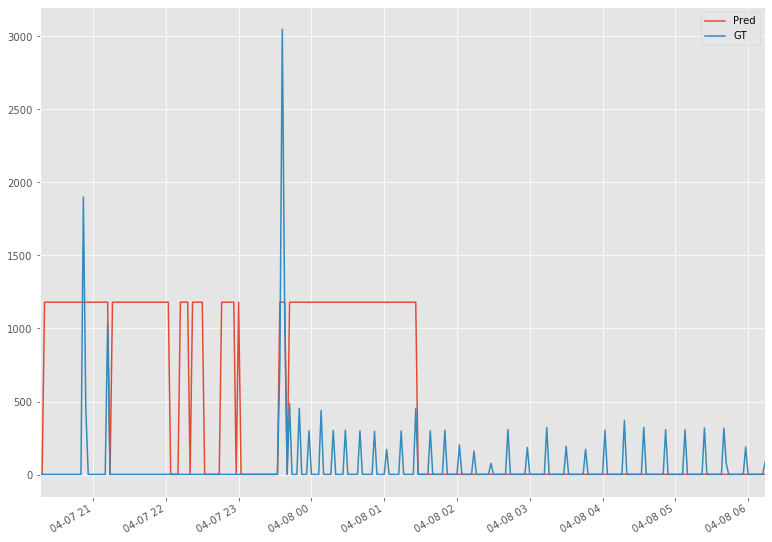

In [35]:
predictions['FHMM']['kettle'].tail(300).plot(label="Pred")
gt['kettle'].tail(300).plot(label="GT")
plt.legend()

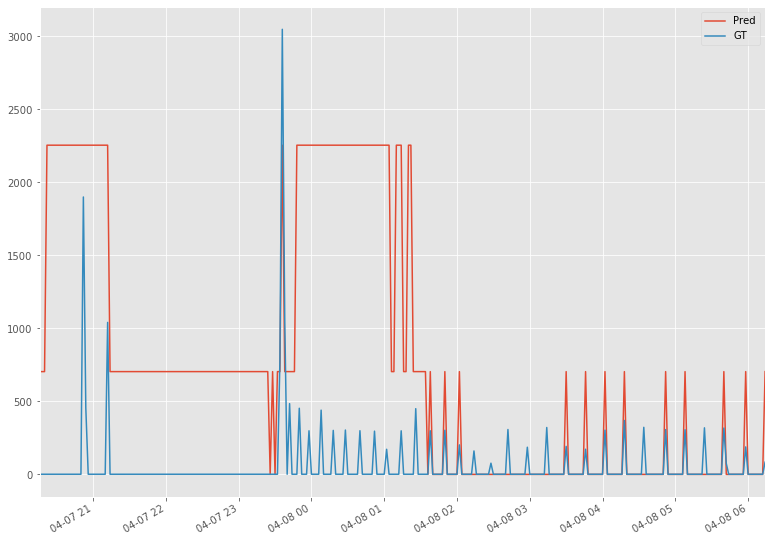

In [36]:
predictions['CO']['kettle'].tail(300).plot(label="Pred")
gt['kettle'].tail(300).plot(label="GT")
plt.legend()